In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import GridSpec

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 200)

In [3]:
df = pd.read_excel('D:/work2022_2023/excel/Обьединенные_данные_за_все_время/Все_данные/proff_20%_with_errors/расчет_соц_успешности_2вар/soc_suc.xlsx')
df.columns

Index(['vk_id', 'kmeans_x', 'friends_2', 'followers_2', 'photos_2', 'videos_2', 'audios_2', 'pages_2', 'post_count_2', 'post_likes_2', 'all_repost_count_2', 'all_repost_likes_2', 'repost_count_2',
       'repost_likes_2', 'repost_comm_count_2', 'repost_comm_likes_2', 'views_2', 'reverse_repost_2', 'photos_count_2', 'photos_likes_2', 'videos_count_2', 'videos_likes_2', 'page_degree_2',
       'online_2', 'online_count_2', 'Отношение', 'Элементы', 'Ребра', 'Друзья', 'Плотность', 'Коэффициент кластеризации', 'Центральность по степени', 'Центральность по близости', 'Новое_отношение',
       'reverse_repost_2.1', 'repost_comm_likes_2 / (repost_comm_count_2 + 1)', 'clustering_coefficient', 'degree_centrality', 'views_2.1', 'reverse_repost_2_mod',
       'repost_comm_likes_2 / (repost_comm_count_2 + 1)_mod', 'clustering_coefficient_mod', 'degree_centrality_mod', 'views_2_mod', 'доминирование', 'классы_доминирование',
       '(online_2*online_count_2)/76', 'closeness_centrality', 'repost_count

In [4]:
cols = ['friends_2', 'followers_2', 'photos_2', 'videos_2', 'audios_2', 'pages_2', 'post_likes_2', 'all_repost_count_2',
'all_repost_likes_2', 'repost_likes_2', 'photos_count_2', 'photos_likes_2', 'videos_count_2', 'videos_likes_2', 'классы_доминирование', 'классы_дружелюбие']
df = df[cols].copy()
df.rename(columns={'классы_доминирование': 'domin_labels', 'классы_дружелюбие': 'drugel_labels'}, inplace=True)


In [5]:
target_domin = df[['domin_labels']].copy()
target_drugel = df[['drugel_labels']].copy()

df.drop(columns=['domin_labels', 'drugel_labels'], axis=1, inplace=True)

df_domin = df.copy()
df_drugel = df.copy()

domin_3_class_index = target_domin.loc[target_domin['domin_labels'] == 3].index
target_domin.drop(index=domin_3_class_index, axis=0, inplace=True)
df_domin.drop(index=domin_3_class_index, axis=0, inplace=True)

drugel_3_class_index = target_drugel.loc[target_drugel['drugel_labels'] == 3].index
target_drugel.drop(index=drugel_3_class_index, axis=0, inplace=True)
df_drugel.drop(index=drugel_3_class_index, axis=0, inplace=True)

print(df_domin.shape, df_drugel.shape)

(1584, 14) (1584, 14)


In [6]:
target_domin.loc[target_domin['domin_labels'] <= 2, 'domin_labels'] = 0
target_domin.loc[target_domin['domin_labels'] >= 3, 'domin_labels'] = 1

target_drugel.loc[target_drugel['drugel_labels'] <= 2, 'drugel_labels'] = 0
target_drugel.loc[target_drugel['drugel_labels'] >= 3, 'drugel_labels'] = 1

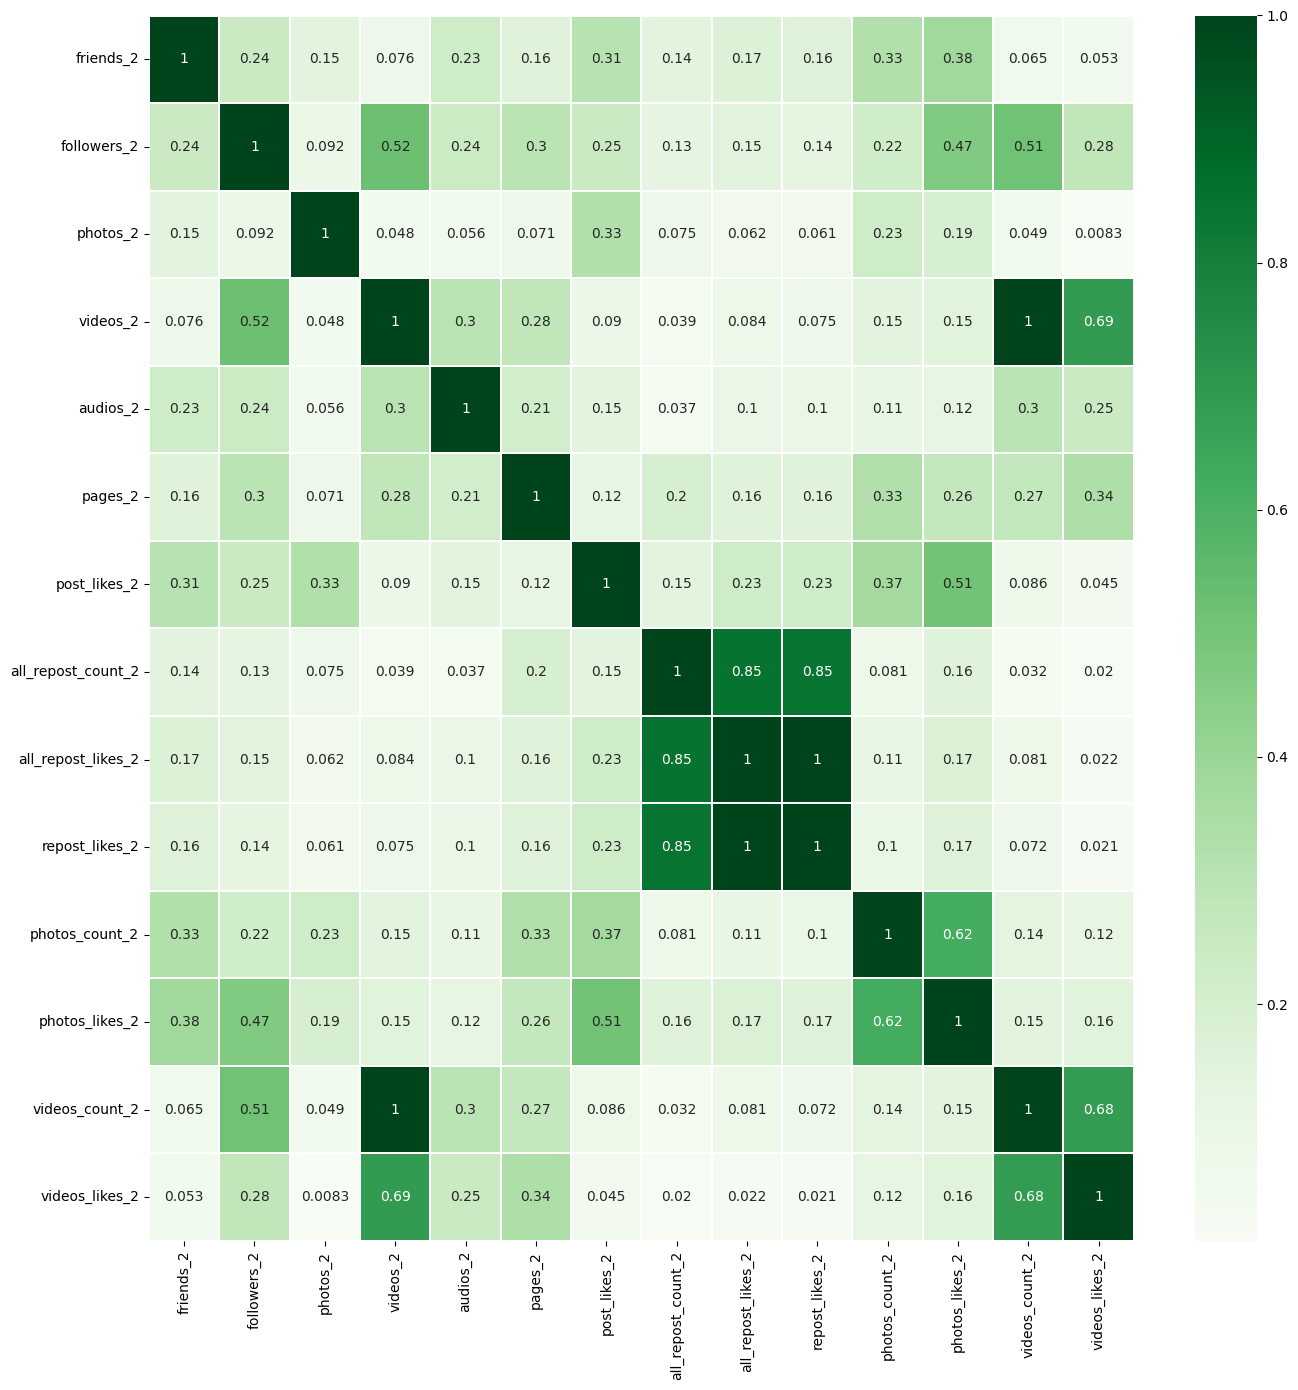

In [7]:
plt.figure(figsize=(14,14))
sns.heatmap(data=df_domin.corr(), cmap='Greens', annot=True, linewidths=0.1)
plt.tight_layout()

In [8]:
df_domin.drop(columns=['videos_count_2', 'videos_likes_2', 'all_repost_likes_2', 'repost_likes_2'], axis=1, inplace=True)
df_drugel.drop(columns=['videos_count_2', 'videos_likes_2', 'all_repost_likes_2', 'repost_likes_2'], axis=1, inplace=True)

In [9]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

import torch

from torch import nn
from torch.utils.data import DataLoader, Dataset

import shap
from captum.attr import IntegratedGradients, NoiseTunnel, FeatureAblation

C:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
st_scaler = StandardScaler()
X_drugel_scalered = pd.DataFrame(st_scaler.fit_transform(df_drugel), columns=df_drugel.columns, index=df_drugel.index)
X_drugel_train, X_drugel_test, y_drugel_train, y_drugel_test = train_test_split(X_drugel_scalered, target_drugel, test_size=0.3)

In [11]:
st_scaler = StandardScaler()
X_domin_scalered = pd.DataFrame(st_scaler.fit_transform(df_domin), columns=df_domin.columns, index=df_domin.index)
X_domin_train, X_domin_test, y_domin_train, y_domin_test = train_test_split(X_domin_scalered, target_domin, test_size=0.3)

In [12]:
class MLP(nn.Module):
    def __init__(self, num_feats):
        super().__init__()

        self.lin1 = nn.Linear(in_features=num_feats, out_features=20)
        self.act1 = nn.ReLU()
        self.lin2 = nn.Linear(in_features=20, out_features=10)
        self.act2 = nn.ReLU()
        self.drop = nn.Dropout()
        self.lin3 = nn.Linear(in_features=10, out_features=2)
        self.act3 = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.lin1(x)
        x = self.act1(x)
        x = self.lin2(x)
        x = self.act2(x)
        x = self.drop(x)
        x = self.lin3(x)
        x = self.act3(x)
        return x


class MyDataset(Dataset):
    def __init__(self, x, y):
        self.features = torch.tensor(x.to_numpy(), dtype=torch.float32)
        self.labels = torch.tensor(y.to_numpy().ravel(), dtype=torch.float32)

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.labels[idx]
        return x, y


def train(dataloader, model):
    optimizer = torch.optim.Adam(params=model.parameters(), lr=5e-4)
    criterion = nn.CrossEntropyLoss()
    
    correct, all_loss = 0, 0
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        
        optimizer.zero_grad()
        y_pred = model(X)
        correct += int((y_pred.argmax(dim=1) == y).sum())
        
        loss = criterion(y_pred, y.long())
        # all_loss += criterion.item()

        loss.backward()
        optimizer.step()

    return correct / size


def test(dataloader, model):
    model.eval()

    correct = 0
    for X, y in dataloader:
        y_pred = model(X)

        correct += int((y_pred.argmax(dim=1) == y).sum())

    return correct / len(dataloader.dataset)

In [13]:
def compute_cm(ml_model, dataloader):
    ml_model.eval()
    y_true = []
    y_pred = []

    for batch, (X, y) in enumerate(dataloader):
        
        y_pred.extend(ml_model(X).argmax(dim=1).tolist())
        y_true.extend(y.tolist())

    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, columns=['Predicted Negative', 'Predicted Positive'],
                             index=['Actual Negative', 'Actual Positive'])
    print('Confusion Matrix : \n', cm_df)
    TP = cm[1][1]
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    conf_accuracy = (float(TP + TN) / float(TP + TN + FP + FN))
    conf_misclassification = 1 - conf_accuracy
    conf_sensitivity = (TP / float(TP + FN))
    conf_specificity = (TN / float(TN + FP))
    conf_precision = (TN / float(TN + FP))
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))

    print(f'Accuracy: {round(conf_accuracy, 2)}')
    print(f'Mis-Classification: {round(conf_misclassification, 2)}')
    print(f'Sensitivity: {round(conf_sensitivity, 2)}')
    print(f'Specificity: {round(conf_specificity, 2)}')
    print(f'Precision: {round(conf_precision, 2)}')
    print(f'f_1 Score: {round(conf_f1, 2)}')

In [14]:
def shap_sklearn(model, train_x, feature_names, dataset_name):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(train_x)
    
    shap.summary_plot(shap_values[1], train_x, feature_names=feature_names, plot_size=(8, 9), show=False)
    plt.title('Shap method')
    plt.savefig(dataset_name + '.png', dpi=300)
    # plt.show()

In [15]:
def sklearn_ml(X_drugel, y_drugel, X_train, y_train, X_test, y_test, dataset_name):
    classifiers = {
        'RandomForest': RandomForestClassifier(random_state=0)
    }
    RF_grid = {'n_estimators': [50, 100, 150, 200, 250, 300, 400, 500],
               'max_depth': [4, 6, 8, 10, 12, 14, 16]}
    grid = {
        'RandomForest': RF_grid
    }

    clf_best_params = classifiers.copy()

    valid_scores = pd.DataFrame({'Classifier': classifiers.keys(),
                                 'Valid accuracy': np.zeros(len(classifiers))})
    i = 0
    for key, classifier in classifiers.items():
        clf = GridSearchCV(estimator=classifier, param_grid=grid[key], scoring='accuracy',
                           n_jobs=-1, cv=2)

        clf.fit(X_train, y_train.values.ravel())

        valid_scores.iloc[i, 1] = clf.score(X_test, y_test.values.ravel())
        clf_best_params[key] = clf.best_params_

    print(valid_scores)

    best_classifiers = {
        'RandomForest': RandomForestClassifier(**clf_best_params['RandomForest'], random_state=0)
    }

    FOLDS = 7

    for key, classifier in best_classifiers.items():
        cv = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=0)

        score = 0
        for fold, (train_idx, val_idx) in enumerate(cv.split(X_drugel, y_drugel.values.ravel())):
            X_train_f, X_valid_f = X_drugel.iloc[train_idx], X_drugel.iloc[val_idx]
            y_train_f, y_valid_f = y_drugel.iloc[train_idx], y_drugel.iloc[val_idx]

            clf = classifier
            clf.fit(X_train_f, y_train_f.values.ravel())

            score += clf.score(X_valid_f, y_valid_f)

        print(score / FOLDS)
    
    feats_names = X_train.columns.tolist()
    
    shap_sklearn(best_classifiers['RandomForest'], X_train, feats_names, dataset_name)

In [16]:
def captum_nn(model, test_x, feature_names, dataset_name):
    model.eval()

    ig = IntegratedGradients(model)
    ig_nt = NoiseTunnel(ig)
    fa = FeatureAblation(model)

    test_x.requires_grad_()

    ig_attr = ig.attribute(test_x, target=1)
    ig_nt_attr_test = ig_nt.attribute(test_x, target=1)
    fa_attr_test = fa.attribute(test_x, target=1)

    ig_attr = ig_attr.detach().numpy()
    ig_nt_attr_test = ig_nt_attr_test.detach().numpy()
    fa_attr_test = fa_attr_test.detach().numpy()

    fig = plt.figure(figsize=(10, 9), layout="constrained")

    x_pos = (np.arange(len(feature_names)))

    gs = GridSpec(2, 4, figure=fig, wspace=0.08, hspace=0.08)

    ax1 = fig.add_subplot(gs[0, 1:3])
    ax1.set_title('IG', pad=10, fontsize=14)
    ax1.set_xticks(x_pos, feature_names, wrap=True, rotation=75)
    ax1.tick_params(axis='x', which='major', pad=5)
    for label in ax1.get_xticklabels(minor=False):
        label.set_horizontalalignment('right')
    ax1.set_xlabel('Features', fontsize=12)
    ax1.bar(x_pos, np.mean(ig_attr, axis=0), align='center')

    ax2 = fig.add_subplot(gs[-1, :2])
    ax2.set_title('IG with NoiseTunnel', pad=10, fontsize=14)
    ax2.set_xticks(x_pos, feature_names, wrap=True, rotation=75)
    ax2.tick_params(axis='x', which='major', pad=5)
    for label in ax2.get_xticklabels(minor=False):
        label.set_horizontalalignment('right')
    ax2.set_xlabel('Features', fontsize=12)
    ax2.bar(x_pos, np.mean(ig_nt_attr_test, axis=0), align='center')

    ax3 = fig.add_subplot(gs[-1, 2:])
    ax3.set_title('Feature Ablation', pad=10, fontsize=14)
    ax3.set_xticks(x_pos, feature_names, wrap=True, rotation=75)
    ax3.tick_params(axis='x', which='major', pad=5)
    for label in ax3.get_xticklabels(minor=False):
        label.set_horizontalalignment('right')
    ax3.set_xlabel('Features', fontsize=12)
    ax3.bar(x_pos, np.mean(fa_attr_test, axis=0), align='center')
    plt.savefig(dataset_name + '_captum.png', dpi=300)

In [17]:
def nn_model(X_train, X_test, y_train, y_test, current_df, dataset_name):
    train_ds = MyDataset(X_train, y_train)
    test_ds = MyDataset(X_test, y_test)

    train_loader = DataLoader(dataset=train_ds, batch_size=64, shuffle=True)
    test_loader = DataLoader(dataset=test_ds, batch_size=64, shuffle=True)

    model = MLP(num_feats=current_df.shape[1])

    epochs = 300

    accs = {'train': [], 'test': []}

    for i in range(1, epochs):
        print(f'Epoch: {i}')
        train_acc = train(train_loader, model)
        test_acc = test(test_loader, model)
        print(f'train acc: {train_acc}')
        print(f'test acc: {test_acc}')

        accs['train'].append(train_acc)
        accs['test'].append(test_acc)

    fig = plt.figure(figsize=(10, 5))
    plt.plot(accs['train'], label='train')
    plt.plot(accs['test'], label='test')
    plt.legend()
    plt.title('Accuracy')
    plt.tight_layout()

    plt.savefig(dataset_name + '_accuracy.png', dpi=300)
    plt.show()
    
    compute_cm(model, test_loader)

    features_names = X_test.columns.tolist()

    test_input_tensor = torch.from_numpy(X_test.to_numpy()).type(torch.FloatTensor)
    captum_nn(model, test_input_tensor, features_names, dataset_name)


     Classifier  Valid accuracy
0  RandomForest        0.701681
0.7064748241505484


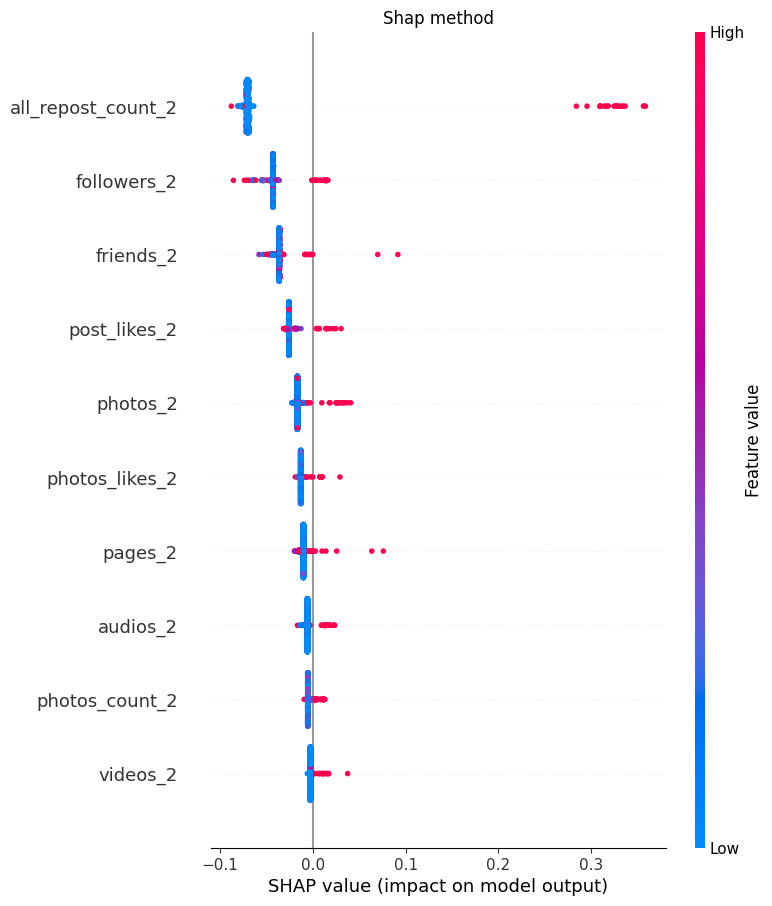

In [18]:
sklearn_ml(df_drugel, target_drugel, X_drugel_train, y_drugel_train, X_drugel_test, y_drugel_test, 'Дружелюбие')

Epoch: 1
train acc: 0.5090252707581228
test acc: 0.5105042016806722
Epoch: 2
train acc: 0.5126353790613718
test acc: 0.5147058823529411
Epoch: 3
train acc: 0.516245487364621
test acc: 0.5168067226890757
Epoch: 4
train acc: 0.5171480144404332
test acc: 0.5189075630252101
Epoch: 5
train acc: 0.51985559566787
test acc: 0.5189075630252101
Epoch: 6
train acc: 0.5270758122743683
test acc: 0.523109243697479
Epoch: 7
train acc: 0.5315884476534296
test acc: 0.5273109243697479
Epoch: 8
train acc: 0.529783393501805
test acc: 0.5357142857142857
Epoch: 9
train acc: 0.5342960288808665
test acc: 0.5504201680672269
Epoch: 10
train acc: 0.546028880866426
test acc: 0.5588235294117647
Epoch: 11
train acc: 0.5550541516245487
test acc: 0.5651260504201681
Epoch: 12
train acc: 0.5541516245487365
test acc: 0.5630252100840336
Epoch: 13
train acc: 0.5649819494584838
test acc: 0.5840336134453782
Epoch: 14
train acc: 0.5839350180505415
test acc: 0.5945378151260504
Epoch: 15
train acc: 0.5794223826714802
test acc:

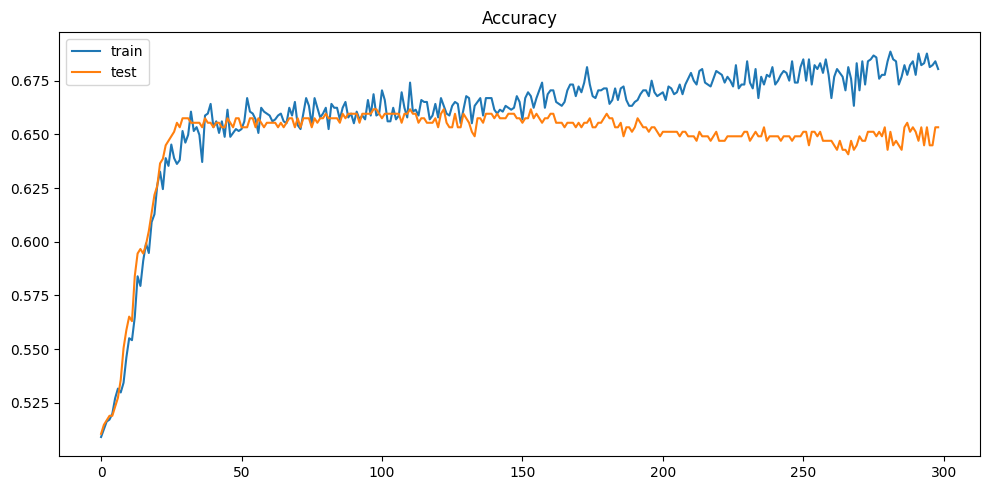

Confusion Matrix : 
                  Predicted Negative  Predicted Positive
Actual Negative                 185                  52
Actual Positive                 113                 126
Accuracy: 0.65
Mis-Classification: 0.35
Sensitivity: 0.53
Specificity: 0.78
Precision: 0.78
f_1 Score: 0.63


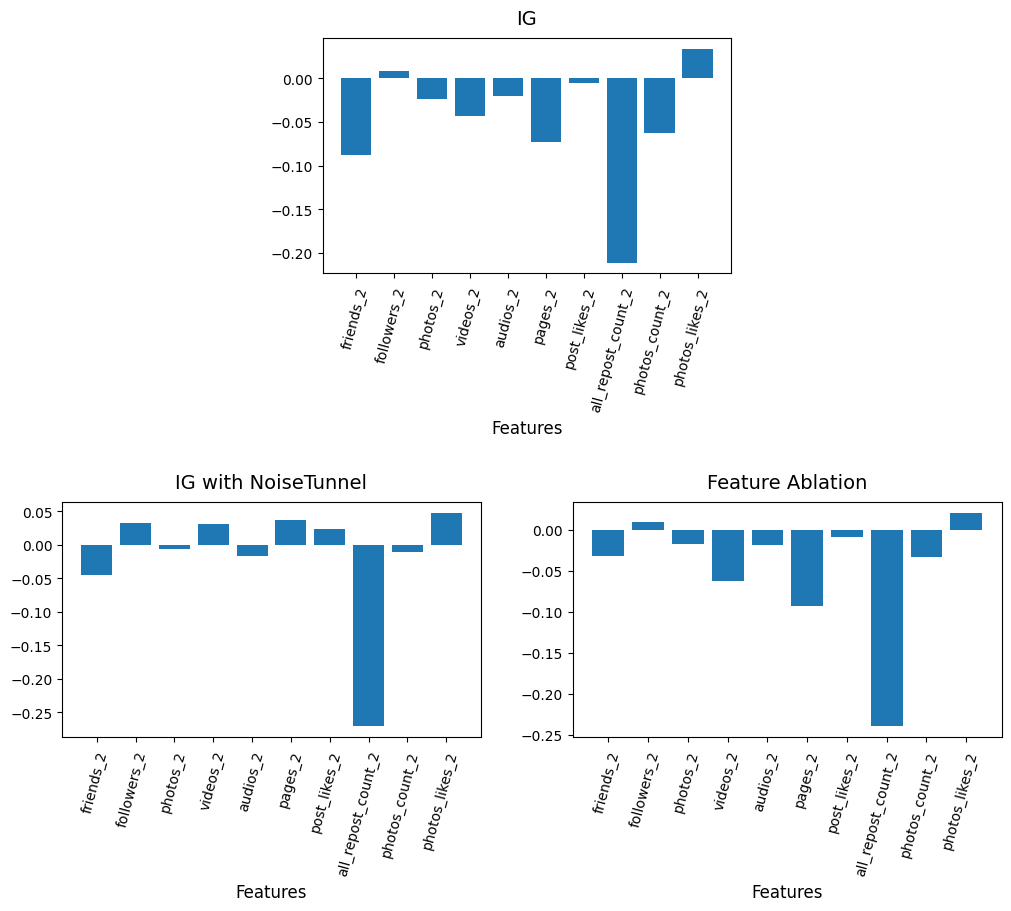

In [19]:
nn_model(X_drugel_train, X_drugel_test, y_drugel_train, y_drugel_test, df_drugel, 'Дружелюбие')

     Classifier  Valid accuracy
0  RandomForest        0.886555
0.8964841248183028


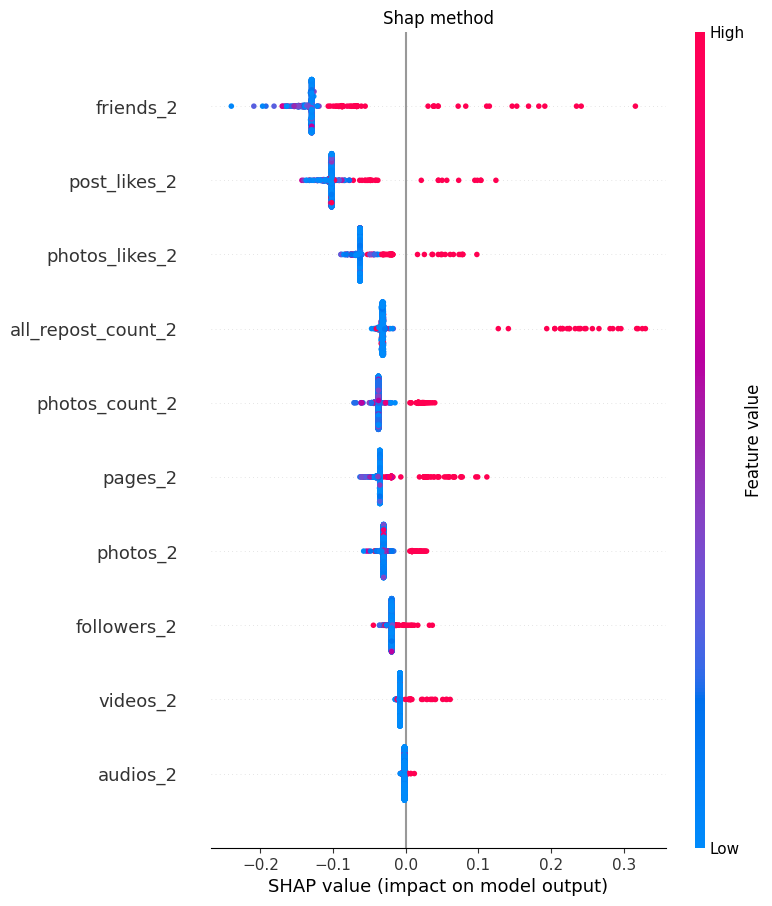

In [20]:
sklearn_ml(df_domin, target_domin, X_domin_train, y_domin_train, X_domin_test, y_domin_test, 'Доминирование')

Epoch: 1
train acc: 0.4927797833935018
test acc: 0.5252100840336135
Epoch: 2
train acc: 0.49458483754512633
test acc: 0.5273109243697479
Epoch: 3
train acc: 0.5
test acc: 0.5357142857142857
Epoch: 4
train acc: 0.5180505415162455
test acc: 0.5399159663865546
Epoch: 5
train acc: 0.5370036101083032
test acc: 0.569327731092437
Epoch: 6
train acc: 0.5478339350180506
test acc: 0.5945378151260504
Epoch: 7
train acc: 0.5866425992779783
test acc: 0.6512605042016807
Epoch: 8
train acc: 0.5911552346570397
test acc: 0.6617647058823529
Epoch: 9
train acc: 0.6191335740072202
test acc: 0.6953781512605042
Epoch: 10
train acc: 0.6263537906137184
test acc: 0.707983193277311
Epoch: 11
train acc: 0.6543321299638989
test acc: 0.7247899159663865
Epoch: 12
train acc: 0.6651624548736462
test acc: 0.7331932773109243
Epoch: 13
train acc: 0.674187725631769
test acc: 0.7415966386554622
Epoch: 14
train acc: 0.6904332129963899
test acc: 0.7478991596638656
Epoch: 15
train acc: 0.7030685920577617
test acc: 0.76470588

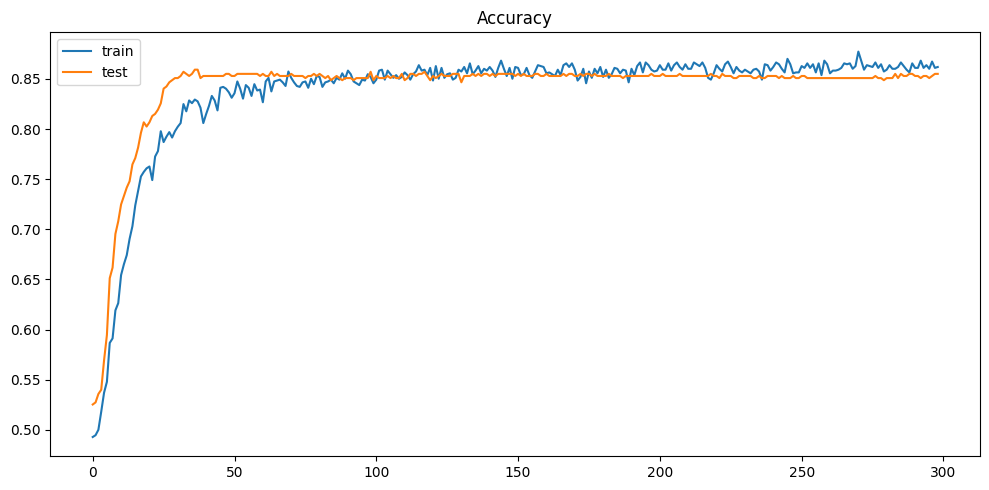

Confusion Matrix : 
                  Predicted Negative  Predicted Positive
Actual Negative                 214                  36
Actual Positive                  33                 193
Accuracy: 0.86
Mis-Classification: 0.14
Sensitivity: 0.85
Specificity: 0.86
Precision: 0.86
f_1 Score: 0.85


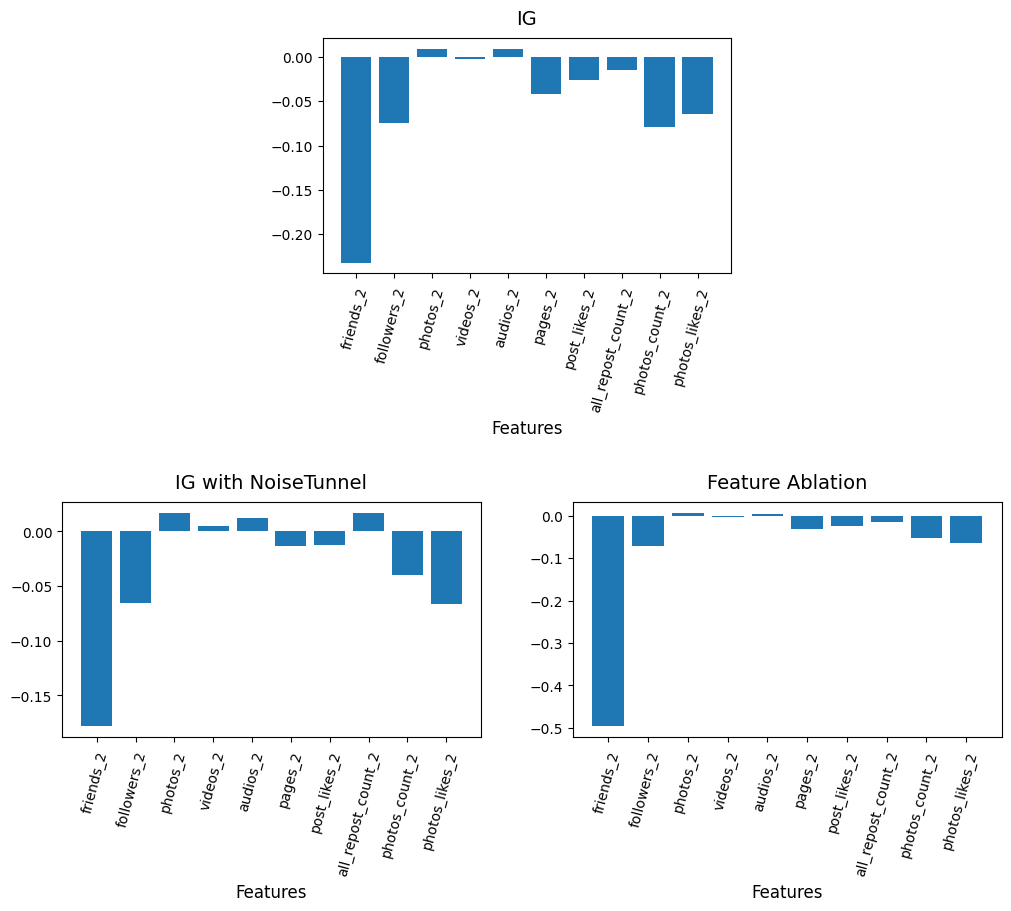

In [21]:
nn_model(X_domin_train, X_domin_test, y_domin_train, y_domin_test, df_domin, 'Доминирование')